In [32]:
import numpy as np
from PIL import Image
import matplotlib.pylab as plt

In [230]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils as utils
from torch.autograd import Variable

In [4]:
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [5]:
%matplotlib inline

In [216]:
path_data_train = '/home/andrii/workspace/data/dtd/train'
path_data_test = '/home/andrii/workspace/data/dtd/test'

args_batch_size = 50
args_dunkeys = 4
args_scale = 128        # 224, 128, 64 # TODO: choose the better name

In [217]:
# [assignment] implement this function
# hint: look at realization of 'normalize' transform in 
# https://github.com/pytorch/vision/blob/master/torchvision/transforms.py
def unnormalize(tensor, mean, std):    
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor    

In [218]:
# ~+~ may be add other transforms here (rotation?)

# general transform

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=imagenet_mean,
                                 std=imagenet_std)

train_transforms = transforms.Compose([
                                      transforms.Scale(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Scale(args_scale),
                                      transforms.ToTensor(),
                                      normalize
                                      ])

test_transforms = transforms.Compose([
                                    transforms.Scale(256),
                                    transforms.CenterCrop(224),
                                    transforms.Scale(args_scale),
                                    transforms.ToTensor(),
                                    normalize
                                    ])

In [219]:
train_dataset = dsets.ImageFolder(root=path_data_train,
                                  transform=train_transforms,
                                  target_transform=None)

val_dataset = dsets.ImageFolder(root=path_data_test,
                                transform=test_transforms,
                                target_transform=None)

In [220]:
image, label = val_dataset[20]
print (image.size())
print (label)
print (train_dataset.classes[label])

torch.Size([3, 128, 128])
42
veined


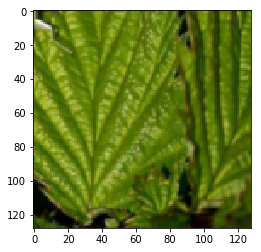

In [221]:
image = unnormalize(image, imagenet_mean, imagenet_std)
img_back = image.mul(255).byte()
im_res = np.transpose(img_back.numpy(), (1, 2, 0))

plt.imshow(im_res)

In [ ]:
# TODO : what is 'pin_memory=True' as a parameter (seems to work only on GPU)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args_batch_size,
                                           shuffle=True,
                                           num_workers=args_dunkeys)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=args_batch_size,
                                         shuffle=False,
                                         num_workers=args_dunkeys)

In [222]:
# When iteration starts, queue and thread start to load dataset from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

print (images.size())
print (labels.size())
print (images.view(-1, args_scale*args_scale*3).size())

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [224]:
input_size = args_scale*args_scale*3
num_classes = len(train_dataset.classes)
num_hidden = 100
learning_rate = 0.01
num_epochs = 50

In [225]:
# log-regression model [~ 6 % accuracy, 32x32]
class LogisticRegression(nn.Module):
    def __init__(self, n_input, n_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input, n_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

In [226]:
# two-layer network [~ 7 % accuracy, 32x32]
class FullyConnected(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super(FullyConnected, self).__init__()
        self.linear1 = nn.Linear(n_input, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out

In [227]:
# conv [ ~16   % accuracy, 28x28, original conv example from tutorial]
# conv [ ~21.2 % accuracy, 32x32]
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4 * 4 * 64, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [228]:
# [assignment] calculate the size of the input for FC layer, when we change the size of the input image
# [for assignment] tools for the analysing errors

# model = FullyConnected(input_size, num_hidden, num_classes)
model = CNN(num_classes)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [1]:
def make_test(data_loader, model_current, n_input, pref=''):

    model.eval()

    # test
    correct = 0
    total = 0
    for images_, labels_ in data_loader:
        #images_ = Variable(images_.view(-1, n_input))  # ONLY for FC net or log regression
        images_ = Variable(images_)
        outputs_ = model_current.forward(images_)
        _, predicted = torch.max(outputs_.data, 1)
        total += labels_.size(0)
        correct += (predicted == labels_).sum()
    print('accuracy[' + pref + '] : %f %%' % (100 * correct / total))

In [91]:
make_test(val_loader, model, input_size)

# train
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #images = Variable(images.view(-1, input_size))  # ONLY for FC net or log regression
        images = Variable(images)
        labels = Variable(labels)

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print('epoch: [%d/%d], step: [%d/%d], loss: %.4f' %
        #       (epoch + 1, num_epochs, i+1, len(train_dataset)//args_batch_size, loss.data[0]))

    print('--- epoch: [%d, %d]' % (epoch + 1, num_epochs))
    make_test(train_loader, model, input_size, pref='train')
    make_test(val_loader, model, input_size, pref='val ')

    # switch back to the training  mode
    model.train()

accuracy[] : 1.595745 %
--- epoch: [1, 50]
accuracy[train] : 2.606383 %
accuracy[val ] : 2.606383 %
--- epoch: [2, 50]
accuracy[train] : 3.164894 %
accuracy[val ] : 3.510638 %
--- epoch: [3, 50]
accuracy[train] : 5.505319 %
accuracy[val ] : 4.361702 %
--- epoch: [4, 50]
accuracy[train] : 6.569149 %
accuracy[val ] : 7.021277 %
--- epoch: [5, 50]
accuracy[train] : 8.005319 %
accuracy[val ] : 7.606383 %
--- epoch: [6, 50]
accuracy[train] : 10.265957 %
accuracy[val ] : 9.308511 %
--- epoch: [7, 50]
accuracy[train] : 12.260638 %
accuracy[val ] : 10.478723 %
--- epoch: [8, 50]
accuracy[train] : 12.500000 %
accuracy[val ] : 11.117021 %
--- epoch: [9, 50]
accuracy[train] : 13.430851 %
accuracy[val ] : 11.489362 %
--- epoch: [10, 50]
accuracy[train] : 13.750000 %
accuracy[val ] : 11.489362 %
--- epoch: [11, 50]
accuracy[train] : 14.281915 %
accuracy[val ] : 11.755319 %
--- epoch: [12, 50]
accuracy[train] : 15.984043 %
accuracy[val ] : 13.351064 %
--- epoch: [13, 50]
accuracy[train] : 15.691489 